# Solving the n-Queens Problem using Local Search

## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation (you can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or search algorithms),
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

np.random.seed(1234)


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))


def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


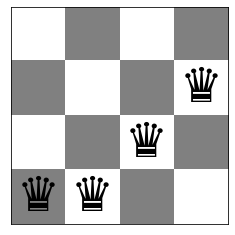

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [3]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


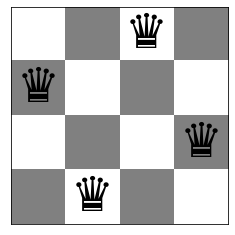

In [4]:
board = [1,3,0,2]
show_board(board)

## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

__Documentation__

* Neighbor states: each state has a maximum of $2n$ neighbors, which are defined as a board in which one queen has moved either up or down from the original board. In code, this is implemented in the $generateNeighbors$ function, calculated by treating the board as a vector, and adding or subtracting the n-dimensional basis vectors from the board vector. The $randNeighbor$ function generates one random neighbor from the given board.
* Steepest ascend implementation: the algorithm is implemented using a while loop. In each iteration, the neighbors of the current board are generated. The neighbors are then ranked by the objective function, so that the board with the smallest number of conflicts is chosen as the successor state. The loop then continues to the next iteration with the best successor. This is repeated until a max number of iterations is achieved, or an optimal solution has been found
* Stochastic implementation: this algorithm works similarly to steepest ascent, however, a random successor is chosen from the available neighbors. The probability of accepting the randomly chosen neighbor is proportional to the decrease in conflicts, implemented by the formula: $P = e^{-1/\Delta E}$, where $\Delta E = conflicts(current) - conflicts(neighbor)$. There is also a 50% chance of accepting a sideways move
* First choice implementation: this algorithm is similar to stochastic hill climbing, except each neighbor is generated randomly, one at a time. The algorithm attempts to generate a better successor up to 100 times. A better successor is instantly accepted, and a sideways move has a 50% chance of being chosen if no better moves are available.

__Additional helper functions__

In [5]:
def generateNeighbors(board):
    """Returns given board's neighboring states as a list"""

    neighbors = list()

    # Neighbors are calculated by doing a vector sum and subtraction of the board with the basis vectors of an nxn matrix
    basisVecs = np.eye(len(board), len(board), dtype=int)

    # Append vector sum and difference to list
    for i in range(len(board)):
        added = np.add(board, basisVecs[i])
        subbed = np.subtract(board, basisVecs[i])

        # Discard invalid boards with out of bounds choices
        if -1 not in added and len(board) not in added:
            neighbors.append(added)
        if -1 not in subbed and len(board) not in subbed:
            neighbors.append(subbed)

    return neighbors

def randNeighbor(board):
    """Returns a random neighbor to given board"""
    randColumn = np.random.randint(0, len(board))
    neighbor = np.copy(board) # copy of board
    if neighbor[randColumn] == 0: 
        neighbor[randColumn] += 1
    elif neighbor[randColumn] == (len(board) - 1):
        neighbor[randColumn] -= 1
    else:
        neighbor[randColumn] += np.random.choice([1, -1], p=[0.5, 0.5])
    
    return neighbor
    

In [89]:
def hillClimbing_steep(board, maxIter, outMode):
    iterations = 0
    y = list()
    while iterations < maxIter and conflicts(board) > 0:
        neighbors = generateNeighbors(board)
        if True not in [conflicts(x) < conflicts(board) for x in neighbors]: break # if no local moves are an improvement, the algorithm has finished

        board = min(neighbors, key=conflicts) #assign best neighbor to board
        y.append(conflicts(board))
        iterations += 1

    if outMode == "stats": # stats mode returns conflicts and iterations as a tuple
        return (conflicts(board), iterations) 
    elif outMode == "soln": # solution mode returns the board itself
        return board
    elif outMode == "graph":
        x = range(iterations)
        plt.plot(x, y)
        plt.xlabel("Iteration")
        plt.ylabel("Conflicts")
        plt.show()
    else:
        pass


## Stochastic Hill Climbing 1 [2 Point]

Chooses randomly from among all uphill moves. Make the probability of the choice proportional to the steepness of the uphill move (i.e., with the improvement in conflicts). 

In [85]:
def hillClimbing_stoch(board, maxIter, outMode):
    iterations = 0
    y = list()
    while iterations < maxIter and conflicts(board) > 0:
        iterations += 1
        neighbors = generateNeighbors(board)
        randIdx = np.random.choice(range(len(neighbors)))
        randChoice = neighbors[randIdx]
        
        c = conflicts(board)
        y.append(c)
        objDiff = c - conflicts(randChoice) # compare objective function value between old board and randomly selected neighbor
        if objDiff == 0:
            if np.random.uniform() < 0.5: # 50% chance to accept the new board if it is a sideways move
                board = randChoice
            continue
        elif objDiff < 0:
            continue
        else:
            acceptProb = np.exp(-1/objDiff) # probability is determined using an exponential decay function
            if np.random.uniform() < acceptProb: # avoid selecting if it is not an improvement
                board = randChoice

    if outMode == "stats": # stats mode returns conflicts and iterations as a tuple
        return (conflicts(board), iterations)
    elif outMode == "soln": # solution mode returns the board itself
        return board
    elif outMode == "graph":
        x = range(iterations)
        plt.plot(x, y)
        plt.xlabel("Iteration")
        plt.ylabel("Conflicts")
        plt.show()
    else:
        pass

## Stochastic Hill Climbing 2 [2 Point]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

In [171]:
def hillClimbing_stoch2(board, maxIter, outMode): #first choice hill climbing
    iterations = 0
    iterNoImprove = 0 # tracks number of iterations with no improvement
    y = list()
    while iterations < maxIter and conflicts(board) > 0:
        iterations += 1

        # Generate random neighbors one at a time
        tries = 0
        while tries < 100: # max number of tries to get an improvement from current board before choosing randomly
            neighbor = randNeighbor(board)
            neighborConf = conflicts(neighbor)
            currConf = conflicts(board)

            if neighborConf <= currConf: # allow for uphill or sideways moves
                board = neighbor
                if neighborConf - currConf != 0: iterNoImprove = 0
                else: iterNoImprove += 1
                break
            if tries == 99:
                iterNoImprove += 1
            
            tries += 1
        
        y.append(conflicts(board))

        if iterNoImprove == 50: break # stop the algorithm if there hasn't been any improvement for a while

    if outMode == "stats": # stats mode returns conflicts and iterations as a tuple
        return (conflicts(board), iterations) 
    elif outMode == "soln": # solution mode returns the board itself
        return board
    elif outMode == "graph":
        x = range(iterations)
        plt.plot(x, y)
        plt.xlabel("Iteration")
        plt.ylabel("Conflicts")
        plt.show()
    else:
        pass

## Hill Climbing Search with Random Restarts [1 Point]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algoithm several times with a new random initialization.

__Design__

Hill climbing with restarts runs each algorithm 100 times. If an optimal solution is found, the algorithm ends. The return value is a tuple containing the number of conflicts in the solution, and the number of restarts. Number of restarts will often be 100, but could be less if an optimal solution is found earlier.

In [147]:
def hillClimbing_restarts(board, n, algorithm, maxIter):
    solution = None
    best = 1e9999999
    runs = 0
    for i in range(100):
        attempt = algorithm(board, maxIter, "soln")
        c = conflicts(attempt)
        if c == 0: return (0, i) # no more restarts required if solution is found
        elif c < best:
            best = c
            solution = attempt

        board = random_board(n)
        runs += 1
        
    return (conflicts(solution), runs)

## Compare Performance [2 Points]

Use runtime and objective function value to compare the algorithms. 

* Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

* How do the algorithms scale with problem size?

* What is the largest board each algorithm can solve in a reasonable amount time?

The example below times creating 100 random boards and calculating the conflicts. Reported is the average run time over `N = 100` runs.

For timing you can use the `time` package.

In [11]:
import time

N = 100
total = 0

for i in range(N):
    t0 = time.time()
    for i in range(1,100): conflicts(random_board(8))
    t1 = time.time()
    total += t1 - t0

tm = total/N
    
print(f"This took: {tm * 1e3} milliseconds")

This took: 3.1638622283935547 milliseconds


The `timit` package is useful to measure time for code that is called repeatedly.

In [12]:
import timeit

N = 100

tm = timeit.timeit('for i in range(1,100): conflicts(random_board(8))', 
                   globals = globals(), number = N)/N

print(f"This took: {tm * 1e3} milliseconds")

This took: 3.584828999999985 milliseconds


__Testing Strategy Pattern__

A simple strategy pattern class to test the algorithms

In [98]:
class LSTester:
    """Local search tester class"""
    def __init__(self, ti, mi, res, sa=False):
        self.algo = None
        self.useRestarts = res
        self.iterations = 0
        self.time = 0
        self.scores = 0
        self.numOptimal = 0 # number of times the algorithm produces the optimal solution
        self.testIterations = ti # number of iterations per test
        self.maxIter = mi # max number of iterations within the algorithm
        self.boardSize = 0
        self.sa = sa # different procedure for outputting SA results
        
    def select(self, a) -> None:
        """Changes the internal algorithm to the specified function handle"""
        self.algo = a

    def setBoardSize(self, n) -> None:
        self.boardSize = n

    def execute(self) -> None:
        """Runs the selected algorithm testIterations times"""
        total = 0
        t0 = None
        t1 = None # timing variables need to be in scope here
        confTotal = 0
        iterTotal = 0

        if self.sa: # special procedure for SA
            timeTotal = 0

            for _ in range(self.testIterations):
                t0 = time.time()
                output = simulatedAnnealing(random_board(self.boardSize), "stats")
                t1 = time.time()
                timeTotal += (t1 - t0)
                confTotal += output[0]
                iterTotal += output[1]

            self.time = timeTotal / self.testIterations
            self.scores = confTotal / self.testIterations
            self.iterations = iterTotal / self.testIterations
            return

        if self.useRestarts: # restarts will only run once, since each algo is restarted 100x
            t0 = time.time()
            conf = hillClimbing_restarts(random_board(self.boardSize), self.boardSize, self.algo, self.maxIter)
            t1 = time.time()
            self.scores = conf[0]
            self.iterations = conf[1]
            self.time = (t1 - t0) * 1e3

        else:
            for _ in range(self.testIterations):
                t0 = time.time()
                stats = self.algo(random_board(self.boardSize), self.maxIter, "stats")
                t1 = time.time()
                confTotal += stats[0]
                iterTotal += stats[1]
                if stats[0] == 0: self.numOptimal += 1 # optimal solution found

                total += t1 - t0

        if not self.useRestarts:
            self.time = total / self.testIterations
            self.scores = confTotal / self.testIterations
            self.iterations = iterTotal / self.testIterations

    def exportStats(self) -> tuple:
        """Returns a tuple of the stats for the run
        Format: (board size, average time, average iterations, average score)"""

        if not self.useRestarts:
            self.numOptimal /= self.testIterations
            self.numOptimal *= 100 # num optimal is the percent of optimal solutions out of all test runs
            self.numOptimal = f"{self.numOptimal}%"
            self.time *= 1e3
            return (self.boardSize, self.time, self.iterations, self.scores, self.numOptimal)
        elif self.useRestarts or self.sa:
            return (self.boardSize, self.time, self.iterations, self.scores)
        else:
            pass


    def reset(self) -> None:
        """Reset all stats"""
        self.time = 0
        self.scores = 0
        self.iterations = 0
        self.numOptimal = 0

__Testing procedure and Data__

Each algorithm is tested on several board sizes, with and without restarts.

The performance data is formatted into a table of averages. Each column shows the average of each stat from all runs. The objective function is shown in the conflicts column, and a lower number indicates the algorithm was able to find better solutions more often. I also included a "Percent optimal" column, which is the ratio of optimal solutions found to the total number of runs, expressed as a percent. This metric is a sort of success rate for the algorithm.


Board size: 4


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,0.622082,1.0,1.6,0.0%
1,Stochastic,67.821312,431.2,0.4,60.0%
2,First choice,16.783810,12.7,0.1,90.0%



Board size: 6


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,1.006722,1.3,2.9,0.0%
1,Stochastic,171.059942,912.9,1.2,10.0%
2,First choice,139.858341,64.0,1.4,0.0%



Board size: 8


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,1.781607,2.1,4.1,0.0%
1,Stochastic,211.761904,1000.0,1.6,0.0%
2,First choice,118.441653,75.9,1.8,0.0%



Board size: 10


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,4.688787,3.9,5.3,0.0%
1,Stochastic,226.828837,1000.0,2.3,0.0%
2,First choice,151.112866,81.8,2.6,0.0%



Board size: 12


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,5.196285,3.5,5.8,0.0%
1,Stochastic,257.296968,1000.0,3.4,0.0%
2,First choice,199.634433,95.0,2.9,0.0%



Board size: 14


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,12.042427,5.4,5.8,0.0%
1,Stochastic,275.341511,1000.0,3.7,0.0%
2,First choice,221.809196,83.1,3.1,0.0%



Board size: 16


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,22.021937,4.9,7.6,0.0%
1,Stochastic,402.143621,1000.0,5.2,0.0%
2,First choice,120.593762,90.7,4.0,0.0%



Board size: 18


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,29.370260,4.7,8.5,0.0%
1,Stochastic,430.887699,1000.0,5.3,0.0%
2,First choice,257.330394,97.6,5.0,0.0%



Board size: 20


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,23.370361,6.5,8.8,0.0%
1,Stochastic,413.920474,1000.0,4.8,0.0%
2,First choice,157.877827,104.0,7.0,0.0%



Board size: 22


,Algorithm,Time (ms),Iterations,Conflicts,Percent optimal
0,Steepest ascent,30.925131,7.1,12.0,0.0%
1,Stochastic,626.714897,1000.0,6.0,0.0%
2,First choice,379.822016,113.0,6.4,0.0%


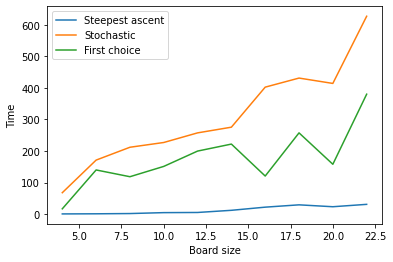

In [148]:
import pandas as pd
from IPython.display import display

tester = LSTester(10, 1000, res=False) # 10 trials with 1000 max iterations
algos = ["Steepest ascent", "Stochastic", "First choice"]
times = list()
iters = list()
scores = list()
optimal = list()

t_steep = list()
t_stoch = list()
t_fc = list() # time arrays for plotting

for i in range(4, 24, 2):
    for algo in [hillClimbing_steep, hillClimbing_stoch, hillClimbing_stoch2]:
        tester.select(algo)
        tester.setBoardSize(i)
        tester.execute()
        
        results = tester.exportStats()
        idx = 1
        for stat in [times, iters, scores, optimal]:
            stat.append(results[idx])
            idx += 1

        # Add times to plot arrays
        if algo is hillClimbing_steep: t_steep.append(results[1])
        elif algo is hillClimbing_stoch: t_stoch.append(results[1])
        elif algo is hillClimbing_stoch2: t_fc.append(results[1])
        else: pass

        tester.reset()
    
    table = {"Algorithm": algos, "Time (ms)": times, "Iterations": iters, "Conflicts": scores, "Percent optimal": optimal}
    df = pd.DataFrame(table)
    print(f"Board size: {i}")
    display(df)
    print()

    for s in [times, iters, scores, optimal]: s.clear()

plt.plot(range(4, 24, 2), t_steep)
plt.plot(range(4, 24, 2), t_stoch)
plt.plot(range(4, 24, 2), t_fc)
plt.xlabel("Board size")
plt.ylabel("Time")
plt.legend(["Steepest ascent", "Stochastic", "First choice"])
plt.show()

__Testing with restarts__

Board size: 4


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,5.539417,12,0
1,Stochastic,339.258909,2,0
2,First choice,138.831139,1,0



Board size: 6


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,97.932339,100,1
1,Stochastic,494.660616,2,0
2,First choice,370.294809,4,0



Board size: 8


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,269.222021,100,1
1,Stochastic,1956.402063,10,0
2,First choice,9073.342085,54,0



Board size: 10


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,362.624168,100,2
1,Stochastic,22512.120485,100,1
2,First choice,17638.443232,95,0



Board size: 12


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,764.278412,100,2
1,Stochastic,29929.542780,100,1
2,First choice,21951.511621,100,1



Board size: 14


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,931.054831,100,3
1,Stochastic,29243.519783,100,1
2,First choice,18824.755192,100,1



Board size: 16


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,1420.342684,100,3
1,Stochastic,30736.975908,100,2
2,First choice,18595.717430,100,1



Board size: 18


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,1698.741674,100,3
1,Stochastic,33837.802649,100,2
2,First choice,19738.909483,100,2



Board size: 20


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,2259.621382,100,5
1,Stochastic,38381.614447,100,3
2,First choice,19297.451973,100,2



Board size: 22


,Algorithm,Time (ms),Iterations,Conflicts
0,Steepest ascent,2956.825256,100,4
1,Stochastic,41219.134569,100,3
2,First choice,21713.943005,100,3


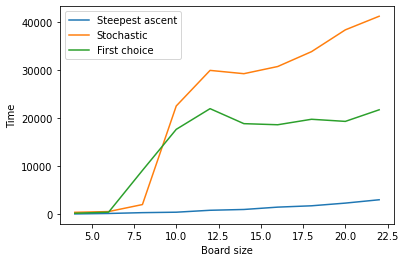

In [170]:
tester = LSTester(1, 1000, res=True) # 10 trials with 1000 max iterations
algos = ["Steepest ascent", "Stochastic", "First choice"]
times = list()
iters = list()
scores = list()

t_steep = list()
t_stoch = list()
t_fc = list() # time arrays for plotting

for i in range(4, 24, 2):
    for algo in [hillClimbing_steep, hillClimbing_stoch, hillClimbing_stoch2]:
        tester.select(algo)
        tester.setBoardSize(i)
        tester.execute()
        
        results = tester.exportStats()
        idx = 1
        for stat in [times, iters, scores]:
            stat.append(results[idx])
            idx += 1

        # Add times to plot arrays
        if algo is hillClimbing_steep: t_steep.append(results[1])
        elif algo is hillClimbing_stoch: t_stoch.append(results[1])
        elif algo is hillClimbing_stoch2: t_fc.append(results[1])
        else: pass

        tester.reset()
    
    table = {"Algorithm": algos, "Time (ms)": times, "Iterations": iters, "Conflicts": scores}
    df = pd.DataFrame(table)
    print(f"Board size: {i}")
    display(df)
    print()

    for s in [times, iters, scores]: s.clear()

plt.plot(range(4, 24, 2), t_steep)
plt.plot(range(4, 24, 2), t_stoch)
plt.plot(range(4, 24, 2), t_fc)
plt.xlabel("Board size")
plt.ylabel("Time")
plt.legend(["Steepest ascent", "Stochastic", "First choice"])
plt.show()

## Graduate student advanced task: Simulated Annealing [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


Implement simulated annealing for the n-Queens problem and compare its performance with the previouse algorithms.

__Implementation__

For this problem, I chose a starting temperature of $1000000$, and an exponential cooling schedule. The cooling schedule is modeled by the equation $T(t) = 1000000(0.09)^t$, where t is time (iteration number). The acceptance probability is implemented the same way as in stochastic hill climbing, with an exponential curve proportional to the improvement of the objective function

In [166]:
def simulatedAnnealing(board, outMode):
    temp = 1000000
    best = board
    bestC = conflicts(board)
    iters = 0
    y = list()
    while temp > 0.001:
        iters += 1
        temp *= (1 - 0.001) # exponential decay schedule
        neighbor = randNeighbor(board)
        c = conflicts(neighbor)
        if c == 0:
            y.append(c)
            bestC = c
            best = neighbor
            break

        dE = c - conflicts(board) # change in energy (objective function)

        # Choose better solution automatically
        if dE < 0:
            board = neighbor
        elif dE == 0:
            if np.random.uniform() <= 0.5: # always a 50% chance of taking sideways moves
                board = neighbor
        else:
            if np.random.uniform() <= np.exp(-dE / temp):
                board = neighbor

        if c < bestC:
            bestC = c
            best = board

        y.append(conflicts(board))

    if outMode == "stats": # stats mode returns conflicts and iterations as a tuple
        return (bestC, iters)
    elif outMode == "soln": # solution mode returns the board itself
        return board
    elif outMode == "graph":
        x = range(iters)
        plt.plot(x, y)
        plt.xlabel("Iteration")
        plt.ylabel("Conflicts")
        plt.show()
    else:
        pass

__SA Testing__

Board size: 4


,Time (ms),Iterations,Conflicts
0,12.846828,155.5,0.0



Board size: 5


,Time (ms),Iterations,Conflicts
0,19.049406,199.6,0.0



Board size: 6


,Time (ms),Iterations,Conflicts
0,996.430731,12292.6,0.4



Board size: 7


,Time (ms),Iterations,Conflicts
0,1352.268934,15143.1,0.5



Board size: 8


,Time (ms),Iterations,Conflicts
0,1882.513642,17785.1,0.7



Board size: 9


,Time (ms),Iterations,Conflicts
0,1876.009703,19517.0,0.8



Board size: 10


,Time (ms),Iterations,Conflicts
0,1834.538484,20713.0,1.2



Board size: 11


,Time (ms),Iterations,Conflicts
0,2031.619453,20713.0,1.6



Board size: 12


,Time (ms),Iterations,Conflicts
0,2467.16888,20713.0,1.7



Board size: 13


,Time (ms),Iterations,Conflicts
0,2032.110667,20190.6,1.8



Board size: 14


,Time (ms),Iterations,Conflicts
0,2089.322734,20713.0,1.7


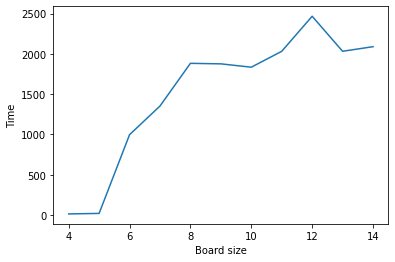

In [168]:
times = list()
iters = list()
scores = list()

timePlot = list()

tester = LSTester(10, 1000, res=False, sa=True)

for i in range(4, 15):
    tester.select(simulatedAnnealing)
    tester.setBoardSize(i)
    tester.execute()
    
    results = tester.exportStats()
    idx = 1
    for stat in [times, iters, scores]:
        stat.append(results[idx])
        idx += 1

    # Add times to plot arrays
    timePlot.append(results[1])

    tester.reset()
    
    table = {"Time (ms)": times, "Iterations": iters, "Conflicts": scores}
    df = pd.DataFrame(table)
    print(f"Board size: {i}")
    display(df)
    print()

    for s in [times, iters, scores]: s.clear()

plt.plot(range(4, 15), timePlot)
plt.xlabel("Board size")
plt.ylabel("Time")
plt.show()

__Learning curve comparisons__

These plots show how the solution improves over time in each algorithm for a board size of 100.

Steepest ascent


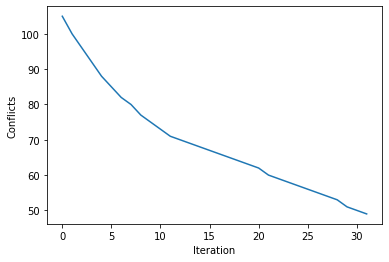

Stochastic


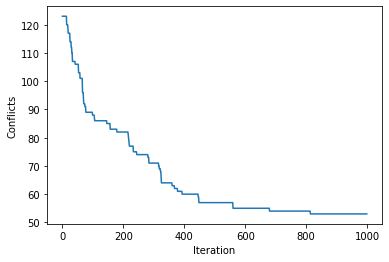

First choice


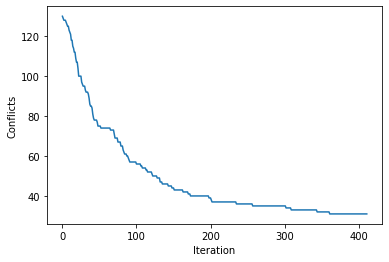

Simulated annealing


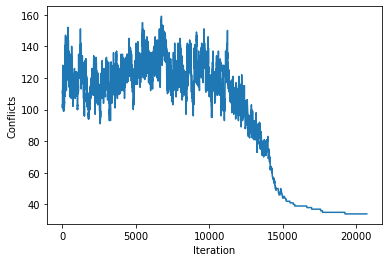

In [169]:
print("Steepest ascent")
hillClimbing_steep(random_board(100), 1000, "graph")
print("Stochastic")
hillClimbing_stoch(random_board(100), 1000, "graph")
print("First choice")
hillClimbing_stoch2(random_board(100), 1000, "graph")
print("Simulated annealing")
simulatedAnnealing(random_board(100), "graph")

### Analysis

__Steepest ascent hill climbing__

Steepest ascent is the best algorithm in terms of time, but the worst in terms of finding a good solution. Since steepest ascent always chooses the best neighbor, it is guaranteed to get stuck in a local optimum. Steepest ascent can only find the optimal solution by chance, that is, if the starting point happens to be directly downhill from the optimal solution. The time advantage from steepest ascent comes from the fact that the algorithm terminates once a local optimum is reached. At a local optimum, there is no neighbor with a better objective function, so it cannot improve any further. The fact that the algorithm terminates so quickly indicates that the solution space is likely very bumpy (has many local optima)

__Stochastic hill climbing__

Stochastic hill climbing is the least time efficient algorithm (for board sizes larger than 8). It is faster than first choice hill climbing for smaller boards, but it scales up quickly, while first choice hill climbing seems to plateau. In my stochastic hill climbing implementation, the acceptance probability for the neighbor was proportional to the improvement by an exponential curve. There was also a constant 50% chance of accepting a sideways move with no improvement. I think allowing sideways moves is a strenght for this algorithm, because although a sideways move offers no improvment, a sideways move could result in a state where better neighbors are accessible. As seen in the learning curve, sideways moves tend to happen more as the number of iterations increases. This shows that plateaus in the search space are more common as the objective function decreases.

__First choice hill climbing__

First choice hill climbing was in the middle in terms of time, but tended to find the best solutions. The time scales with the board size sharply at the beginning, but then grows slower as the board size increases past 8. The algorithm is slow likely because the chances of randomly generating a better neighbor get worse as the current solution gets better. The algorithm has 100 attempts to randomly generate a better neighbor, and if none is found, the algorithm continues to the next iteration with the same board. I believe that this 100 attempt limit is what causes the timing to plateau as the board size increases past 8.

__Simulated annealing__

Simulated annealing is the best all around algorithm. Its execution time does seem to scale linearly with the size of the board, but the solutions it returns are typically better than the other algorithms. SA does a good job at escaping local optima, however, it seems that the search space is full of local optima, so it still fails to find the optimal solution for larger boards.

## More things to do

Implement a Genetic Algorithm for the n-Queens problem.

In [17]:
# Code and description go here